In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim

In [ ]:
### LOAD IN DATA ###

batch_size = 64

train = datasets.MNIST('./data', train=True, download=True, 
                          transform=transforms.ToTensor())

trainloader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=2)

test = datasets.MNIST('./data', train=False, download=True, 
                          transform=transforms.ToTensor())

testloader = DataLoader(test, batch_size=batch_size, shuffle=True, num_workers=2)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


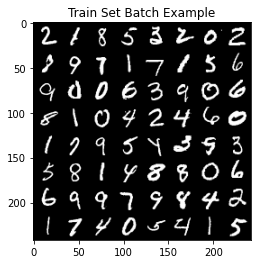

In [ ]:
### VISUALIZE IMAGES ###

def show_images(image_batch, title:str):
  grid = torchvision.utils.make_grid(image_batch)
  plt.imshow(grid[0], cmap='gray')
  plt.title(title)
  plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()
show_images(images, 'Train Set Batch Example')

In [ ]:
### CREATE THE MACHINE ###

class VAE(nn.Module):
  def __init__(self, z_dim):
    super(VAE, self).__init__()
    ### ENCODER LAYERS ###
    self.lin1 = nn.Linear(784, 400)
    self.lin2mu = nn.Linear(400, z_dim)   # encode means
    self.lin2var = nn.Linear(400, z_dim)  # encode variances

    ### DECODER LAYERS ###
    self.lin3 = nn.Linear(z_dim, 400)
    self.lin4 = nn.Linear(400, 784)

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.rand_like(std)    # create IID standard normal with same shape as z
    return eps.mul(std).add_(mu)

  def forward(self, x):
    x = x.view(-1, 784)
    x = F.relu(self.lin1(x))
    mu = self.lin2mu(x)
    var = self.lin2var(x)
    z = self.reparameterize(mu, var)
    x = self.decode(z)
    return x, mu, var

  def decode(self, x):
    x = F.relu(self.lin3(x))
    x = torch.sigmoid(self.lin4(x))
    return x


In [ ]:
### LOSS FUNCTION: RECONSTRUCTION LOSS + KL DIVERGENCE ###

def loss_term(x, x_hat, mu, var):
  CE = F.binary_cross_entropy(x_hat, x.view(-1, 784), reduction='sum')
  KLD = -0.5 * torch.sum(1 + var - mu.pow(2) - var.exp())
  return CE + KLD


In [ ]:
### OPT AND HYPERPARAMETERS ###

vae = VAE(z_dim=2)

lr = 1e-4
opt = optim.Adam(vae.parameters(), lr=lr)



Epoch: 1, Average Loss: 3.3716537307739256
Epoch: 2, Average Loss: 2.805770546976725
Epoch: 3, Average Loss: 2.705930272420247
Epoch: 4, Average Loss: 2.6460736788431802
Epoch: 5, Average Loss: 2.6036894556681314
Epoch: 6, Average Loss: 2.574116534169515
Epoch: 7, Average Loss: 2.552918778737386
Epoch: 8, Average Loss: 2.5364874471028647
Epoch: 9, Average Loss: 2.5229982780456544
Epoch: 10, Average Loss: 2.5119024185180665
Epoch: 11, Average Loss: 2.501891742960612
Epoch: 12, Average Loss: 2.493375445810954
Epoch: 13, Average Loss: 2.485490140533447
Epoch: 14, Average Loss: 2.4785537605285644
Epoch: 15, Average Loss: 2.472662656656901
Epoch: 16, Average Loss: 2.465820998128255
Epoch: 17, Average Loss: 2.4607693923950196
Epoch: 18, Average Loss: 2.455710016377767
Epoch: 19, Average Loss: 2.450619086710612
Epoch: 20, Average Loss: 2.446254825846354
Epoch: 21, Average Loss: 2.4420767066955564
Epoch: 22, Average Loss: 2.437926890563965
Epoch: 23, Average Loss: 2.43422662709554
Epoch: 24, A

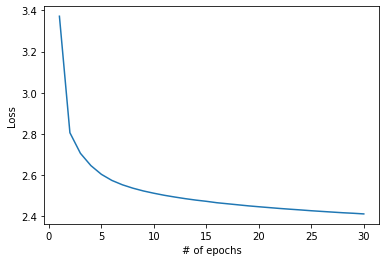

In [ ]:
### TRAINING LOOP ###

epochs = 30
loss_curve = []

for epoch in range(epochs):
  total_loss = 0
  for i, data in enumerate(trainloader, 0):
    x, _ = data
    opt.zero_grad()
    x_hat, mu, var = vae(x)
    loss = loss_term(x, x_hat, mu, var)
    loss.backward()
    total_loss += loss.item()/len(x)
    opt.step()
  avg_epoch_loss = total_loss/ len(trainloader.dataset)
  print(f'Epoch: {epoch+1}, Average Loss: {avg_epoch_loss}')
  loss_curve.append(avg_epoch_loss)

epoch_range = list(range(1, epochs+1))
plt.plot(epoch_range, loss_curve)
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.show()


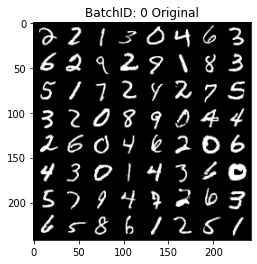

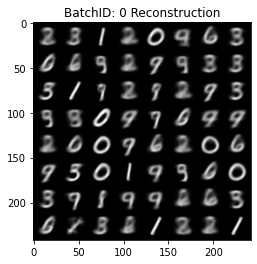

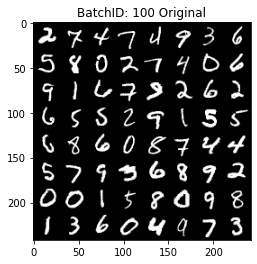

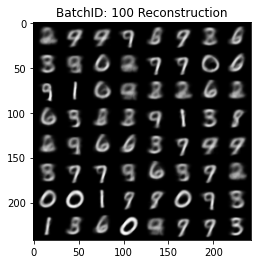

In [ ]:
### TESTING LOOP ###

with torch.no_grad():
  for i, data in enumerate(testloader):
    x, _ = data
    x_hat, mu, var = vae(x)
    try:
      x_hat_ = x_hat.view(batch_size, 1, 28, 28)
    except:
      continue
    if i % 100 == 0:
      show_images(x, f'BatchID: {i} Original')
      show_images(x_hat_, f'BatchID: {i} Reconstruction')
 

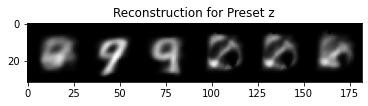

In [ ]:
### GENERATE FROM PRESET LATENT VECTOR ###

with torch.no_grad():
  z = [[0,0], [0,1], [1,1], [-1,-1], [-0.9, -0.9], [-0.5, -0.5]]
  sample = vae.decode(torch.FloatTensor(z))
  sample_ = sample.view(len(z), 1, 28, 28)
  show_images(sample_, 'Reconstruction for Preset z')
  

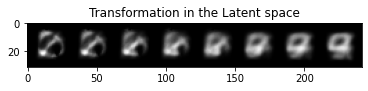

In [ ]:
### SHOW TRANSFORMATION IN THE LATENT SPACE ###

with torch.no_grad():
  z = [[-1, -1],[-0.8, -0.8],[-0.6, -0.6],[-0.4, -0.4], [-0.2, -0.2], [0, 0], [0.2, 0.2], [0.4, 0.4]]
  sample = vae.decode(torch.FloatTensor(z))
  sample_ = sample.view(len(z), 1, 28, 28)
  show_images(sample_, 'Transformation in the Latent space')


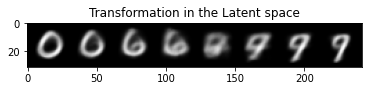

In [ ]:
### MORE TRANSFORMATION IN THE LATENT SPACE ###


with torch.no_grad():
  z = [[0, -2],[0, -1.5],[0, -1],[0, -0.5], [0, 0], [0, 0.5], [0, 1], [0, 1.5]]
  sample = vae.decode(torch.FloatTensor(z))
  sample_ = sample.view(len(z), 1, 28, 28)
  show_images(sample_, 'Transformation in the Latent space')